# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

## This is the Backward pass by hand

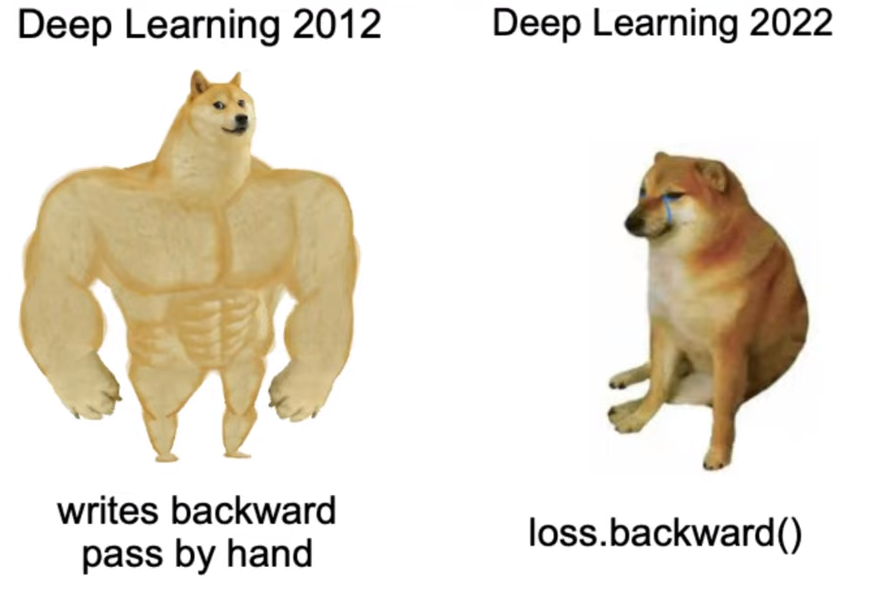

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Dataset and Building vocabulary

The included `names.txt` dataset, as an example, has the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames/) for the year 2018.

In [2]:
# Open the dataset (List of names) as a python list of strings which is words in this case
word= open('names.txt', 'r').read().splitlines()

In [3]:
#First 10 word
word[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(word)

32033

In [5]:
#Building vocabulary
chars=sorted(list(set(''.join(word))))
stoi={c:i+1 for i,c in enumerate(chars)} #Mapping of character to index
stoi['.']=0 #Start/End token
itos={i:c for c,i in stoi.items()} #Mapping of index to character
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
vocab_size = len(itos)

### Building dataset + Split

In [7]:
#Breakdown of the dataset algorithm
block_size=3 #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
X, Y= [], []
for w in word: 
    # print(w)
    context=[0]*block_size 
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print (''.join(itos[i] for i in context), '-->', itos[ix])
        context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx

In [8]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

X ->int64-> [228146, 3] -> 228146 examples (data) and each input to NN is 3 int

Y ->int64-> [228146] -> int label

3 char --> label char

context --> label

In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(word)
n1 = int(0.8*len(word))
n2 = int(0.9*len(word))

Xtr,  Ytr  = build_dataset(word[:n1])     # 80%
Xdev, Ydev = build_dataset(word[n1:n2])   # 10%
Xte,  Yte  = build_dataset(word[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Util function for comparing gradient with torch gradient

In [11]:
# Utility Function
def cmp(s, dt, t):
    # Check if the gradients are exactly equal
    ex = torch.all(dt == t.grad).item()
    # Check if the gradients are approximately equal within a certain tolerance
    app = torch.allclose(dt, t.grad)
    # Calculate the maximum difference between the gradients
    maxdiff = (dt - t.grad).abs().max().item()
    # Print the results
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

### MLP

In [12]:
n_embd = 10 # dimensi embedding
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters (different init before)
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Removing zero init since it may be destroying backward pass implementation

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [15]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [16]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4722, grad_fn=<NegBackward0>)